## ECG Prediction

### Intorduction

The project, led by Omdena Morocco chapter aims to predict or interpret ECG, early, using an application. This could help decrease the number of deaths that occur due to delay of diagnosis or even mis-interpretation.

* [Step 0](#step0): Import Dataset
* [Step 1](#step1): Split the data set
* [Step 2](#step2): Creat Data Loaders
* [Step 3](#step3): Creat Train Function
* [Step 4](#step4): Create Test Function
* [Step 5](#step5): Creat VGG Model
* [Step 6](#step6): Set Hyper Parameters
* [Step 7](#step7): Train The model
* [Step 8](#step8): Test The model accuracy

<a id='step0'></a>
## Step 0: Import Dataset

### Import the Data

In [7]:
import numpy as np
from glob import glob

# load filenames for all images
ECG_files = np.array(glob("./ptb/classified/*/*"))


# print number of images in the dataset
print('There are %d total  images, with different classes' % len(ECG_files))


There are 4387 total  images, with different classes


<a id='step1'></a>
## Step 1: Split the data set

Here I have splitted the available data into test(10%), train(80%) and validation(10%)

In [2]:
import splitfolders

data_dir = './ptb/classified'
splitfolders.ratio(data_dir, output="./ptb/splitted_Data", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 4387 files [00:32, 132.98 files/s]


<a id='step2'></a>
## Step 2: Creat Data Loaders

In [107]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import torch


num_workers = 0


#batch size
batch_size = 20

#convert the data to a normalized tensor
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomVerticalFlip(),                                       
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
    ])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
    ])

data_dir = 'ptb/splitted_Data/'

train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir = os.path.join(data_dir, 'val/')


train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=train_transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

#prepare a dict for all loaders
loaders ={}
loaders['train'] = train_loader
loaders['test'] = test_loader
loaders['valid'] = valid_loader

# get available classes, to be used as the output
classes = []
for cl in train_data.classes:
    classes.append(cl)
print(classes)

print("Number of avaialable classes: " , len(classes))



['MI', 'NORM']
Number of avaialable classes:  2


<a id='step3'></a>
## Step 3: Create Train Function

In [9]:
#define training function
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    #load previous model if it exists, to save time
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    valid_loss_min = 0.542831
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            #clear optimizer
            optimizer.zero_grad()
        
            #compute predicted op
            output = model(data)
        
            #calculate error/loss for this batch
            loss = criterion(output, target)   
            loss.backward()        
            optimizer.step()
            ## record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #train_loss += loss.item() * data.size(0) #multiply by batch size
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model(data)
            loss = criterion(output, target)
            
            #in validation we don't do backward propagation
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            #valid_loss += loss.item()* data.size(0)

        #train_loss = train_loss / len(loaders['train'].dataset)
        #valid_loss = valid_loss / len(loaders['valid'].dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("validation loss decreased {:.6f} --> {:.6f} . saving model .. ".format(valid_loss_min, valid_loss))
            torch.save(model.state_dict() , save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

<a id='step4'></a>
## Step 4: Creat Test Function

In [3]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



<a id='step5'></a>
## Step 5: Creat VGG Model

#### Creating the pre-trained model, VGG

In [4]:
import torchvision.models as models
import torch.nn as nn

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Load the pretrained model from pytorch
model_VGG = models.vgg16(pretrained=True)

# print out the model structure
print(model_VGG)

for param in model_VGG.features.parameters():
    param.requires_grad = False
    
    
n_inputs = model_VGG.classifier[6].in_features

# add last linear layer (n_inputs ->ECG classes)
last_layer = nn.Linear(n_inputs, len(classes))

model_VGG.classifier[6] = last_layer

# check to see that your last layer produces the expected number of outputs
print("output after replacing last layer: ")
print(model_VGG.classifier[6].out_features)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<a id='step6'></a>
## Step 6: Set Hyper Parameters

In [99]:
import torch.optim as optim
n_epochs =10
learning_rate = 0.01
criterion_VGG = nn.CrossEntropyLoss()
optimizer_VGG = optim.SGD(model_VGG.classifier.parameters(), lr=learning_rate )

<a id='step7'></a>
## Step 7: Train the Model

In [100]:
model_VGG = train(n_epochs, loaders, model_VGG, optimizer_VGG, criterion_VGG, use_cuda, 'model_VGG_4.pt')


Epoch: 1 	Training Loss: 0.586508 	Validation Loss: 0.540337
validation loss decreased 0.542831 --> 0.540337 . saving model .. 
Epoch: 2 	Training Loss: 0.589060 	Validation Loss: 0.604733
Epoch: 3 	Training Loss: 0.577083 	Validation Loss: 0.573902
Epoch: 4 	Training Loss: 0.578282 	Validation Loss: 0.542751
Epoch: 5 	Training Loss: 0.567512 	Validation Loss: 0.591211
Epoch: 6 	Training Loss: 0.570410 	Validation Loss: 0.543340
Epoch: 7 	Training Loss: 0.566074 	Validation Loss: 0.519873
validation loss decreased 0.540337 --> 0.519873 . saving model .. 
Epoch: 8 	Training Loss: 0.558358 	Validation Loss: 0.549961
Epoch: 9 	Training Loss: 0.565543 	Validation Loss: 0.553522
Epoch: 10 	Training Loss: 0.552528 	Validation Loss: 0.529972


<a id='step8'></a>
## Step 8: Test the Model

In [108]:
# load the model that got the best validation accuracy 
model_VGG.load_state_dict(torch.load('model_VGG_2.pt'))

<All keys matched successfully>

In [109]:
test(loaders, model_VGG, criterion_VGG, use_cuda)

Test Loss: 0.461194


Test Accuracy: 79% (351/441)


### Test The App

In [86]:
from PIL import Image
import torchvision.transforms as transforms
import cv2

def Model_predict(img_path):
    
    # VGG-16 Takes 224x224 images as input
    data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
    ])
    

    
    transformed_img = data_transform(Image.open(img_path).convert('RGB'))
    #make the tensor 4D, instead of 3D
    transformed_img = transformed_img.unsqueeze(0)
    
    if use_cuda:
        transformed_img = transformed_img.cuda()
        
    output = model_VGG(transformed_img)
    
    if use_cuda:
        output = output.cpu()
        
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    #print(preds)

    pred_class = classes[preds]
        
    print(pred_class)


In [87]:
import matplotlib.pyplot as plt                        
import matplotlib.image as mpimg

def ECG(img_path):
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    
    Model_predict(img_path)

ptb/Test_Model\1_NORM.png


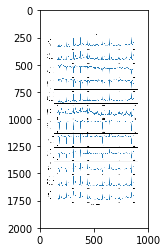

NORM
*******************************************************


ptb/Test_Model\MI(1).jpg


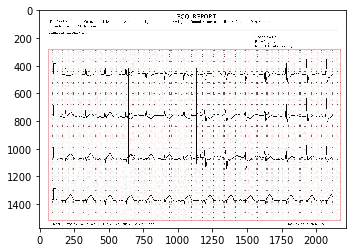

MI
*******************************************************


ptb/Test_Model\MI(2).jpg


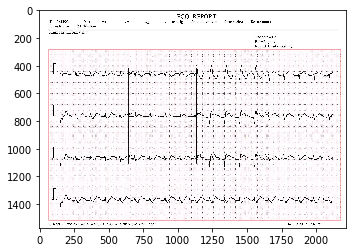

MI
*******************************************************


ptb/Test_Model\Normal(1).jpg


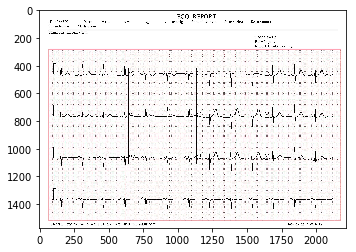

MI
*******************************************************




In [89]:
test_files = np.array(glob("ptb/Test_Model/*"))

for file in test_files:   
    print(file)
    ECG(file)
    print('*******************************************************')
    print("\n")
